In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score
import dill

[[ 0.2782208   0.20921635 -0.15783327 -0.11597944  0.50267757]
 [ 0.20921635  0.62540461 -0.07440552 -0.1590074  -0.34949867]
 [-0.15783327 -0.07440552  0.56790749 -0.23986521 -0.04603175]
 [-0.11597944 -0.1590074  -0.23986521  0.53484125  0.11551827]
 [ 0.50267757 -0.34949867 -0.04603175  0.11551827 -0.10637415]]
(5,) (5, 5)


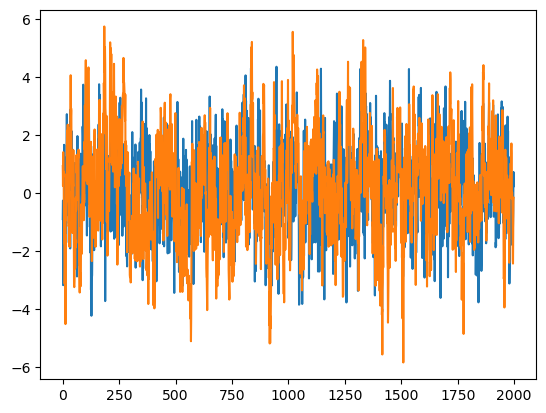

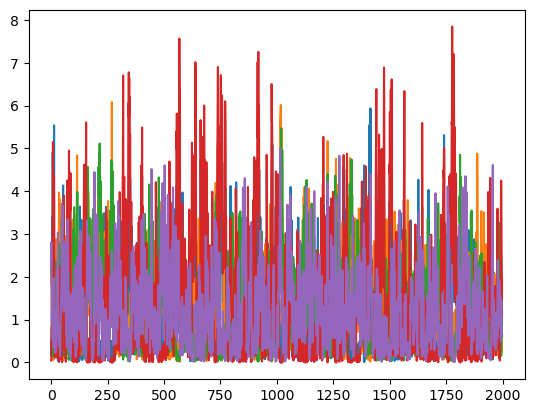

1.1914049979620704


In [2]:
# Simulate some data
torch.manual_seed(0)
np.random.seed(0)
N = 100
z_dim = 5
# x_dim = 5
x_dim = 100

# sqrt m  division in matrix C 

# A = np.array([[0.9, 0.4], [-0.2, 0.8]])
# s = np.array([0.8, 0.99]).reshape(1, -1)
# u, _ = np.linalg.qr(np.random.randn(s.shape[1], s.shape[1]))
# A = u @ np.diag(s.squeeze()) @ u.T
eigs = np.array([-0.6, 0.2, 0.6, 0.8, 0.9])
A = np.diag(eigs)
u, _ = np.linalg.qr(np.random.randn(z_dim, z_dim))
A = u @ A @ u.T
print(A)

# B = np.array([[0.1, 0.0], [0.0, 0.1]])
B = 1 * np.eye(z_dim)
# W = np.eye(x_dim)
W = np.random.randn(x_dim, z_dim) / np.sqrt(z_dim)




# C = np.random.randn(N, x_dim) / np.sqrt(x_dim)
C = np.eye(N)

sigma_x = 0.1

# mu0 = np.array([0., 0.])
# Sigma0 = np.array([[.010, 0.0], [0.0, .010]])
mu0 = np.zeros(z_dim)
Sigma0 = 1 * np.eye(z_dim)
print(mu0.shape, Sigma0.shape)

ntrials = 1
# v0 = np.random.multivariate_normal(mu0, Sigma0)
v0 = mu0 + (np.linalg.cholesky(Sigma0) @ np.random.randn(ntrials,z_dim, 1)).squeeze(-1)

T = 2000
v = np.zeros((ntrials,z_dim,T))
x = np.zeros((ntrials,x_dim,T))
x_noise_free = np.zeros((ntrials,x_dim,T))
v[:,:, 0] = v0
x_noise_free[:,:, 0] = (W @ v0[..., None]).squeeze(-1)
x[:,:, 0] = (W @ v0[..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim,)
for t in range(1, T):
    v[..., t] = (A @ v[..., t-1][..., None]).squeeze(-1) + (B @ np.random.randn(ntrials, z_dim,1)).squeeze(-1)
    x_noise_free[..., t] = (W @ v[..., t][..., None]).squeeze(-1)
    x[..., t] = (W @ v[..., t][..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim)

stop = -1
plt.plot(v[-1,0,:stop])
plt.plot(v[-1,1,:stop])
plt.show()

_d = 0.5
F = C[None, ...] @ x + _d
# plt.plot(F[0,0,:stop])
# plt.plot(F[0,1,:stop])

# link = np.exp
link = lambda x: 1 * np.log(1 + np.exp(x))
dt = 1
for i in range(5):
    plt.plot(link(F[0,i,:stop])*dt)
plt.show()

# Average firing rate
print(np.mean(link(F)))


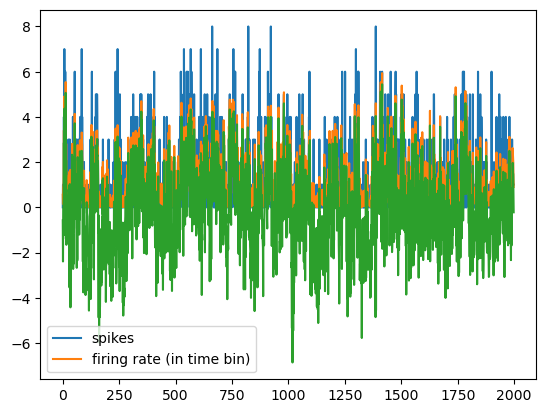

step 0 LL -2.033797023809524
step 1 LL -2.0064885416666667
step 2 LL -1.981509226190476
step 3 LL -1.957765625
step 4 LL -1.9349752976190475
step 5 LL -1.9129270833333334
step 6 LL -1.891642261904762
step 7 LL -1.8710662202380952
step 8 LL -1.8511504464285715
step 9 LL -1.8318558035714285
step 10 LL -1.8132488095238095
step 11 LL -1.7951706845238096
step 12 LL -1.7777252976190476
step 13 LL -1.7608333333333333
step 14 LL -1.7444907738095239
step 15 LL -1.728690625
step 16 LL -1.713475
step 17 LL -1.698699255952381
step 18 LL -1.684421875
step 19 LL -1.670634375
step 20 LL -1.657346875
step 21 LL -1.6444802083333334
step 22 LL -1.63211875
step 23 LL -1.6201245535714286
step 24 LL -1.6085961309523809
step 25 LL -1.597444642857143
step 26 LL -1.586649255952381
step 27 LL -1.5763214285714287
step 28 LL -1.5663025297619049
step 29 LL -1.5566761904761905
step 30 LL -1.5473547619047618
step 31 LL -1.5383857142857142
step 32 LL -1.5297617559523808
step 33 LL -1.5213910714285714
step 34 LL -1.5

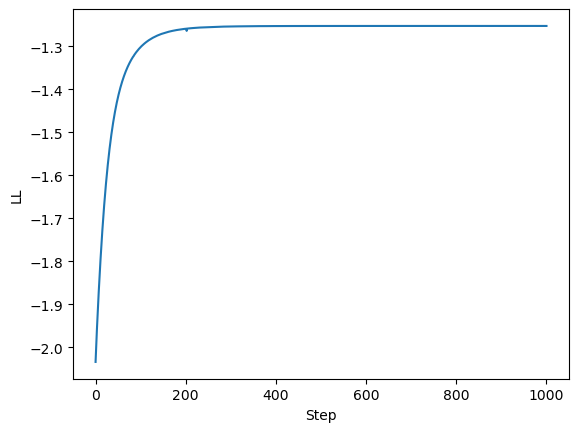

In [3]:
# link_fn = torch.exp
# link = lambda x: np.exp(x)
link_fn = lambda x: 1 * torch.nn.functional.softplus(x)
link = lambda x: 1 * np.log(1 + np.exp(x))
lik = Poisson_noise()
Y = np.random.poisson(link(F)*dt)

train_len = 1000
Y_train = Y[..., :train_len]
v_train = v[..., :train_len]
Y_test = Y[..., train_len:]
v_test = v[..., train_len:]


# sigma = 0.1
# Y = np.random.randn(*F.shape) * sigma + F
# lik = Gaussian_noise(sigma)
# link_fn = lambda x: x

# # Sigmoid link function
# link = lambda x: 1 / (1 + np.exp(-x))
# Y = np.random.negative_binomial(link(F), 0.5)
# lik = Negative_binomial_noise(Tensor(Y))
# link_fn = lambda x:x

plt.plot(Y[0,0,:stop], label='spikes')
# plt.plot(Y[0,1,:stop])
plt.plot(link(F[0,0,:stop])*dt, label='firing rate (in time bin)')
plt.plot(x_noise_free[0,0,:stop])
plt.legend()
plt.show()

# _W = torch.tensor(np.random.randn(1,x_dim, x_dim) / np.sqrt(x_dim)).float().to(device)
# _C = torch.tensor(np.random.randn(1,N, x_dim) / np.sqrt(x_dim)).float().to(device)
model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, fixed_d=False, d=_d, C=Tensor(C).to(device))
model.C.requires_grad = False

train_params = {'batch_size': None, 'n_mc': 500, 'step_size': 500, 'lrate': 1e-2, 'max_steps': 1001, 'gamma': 0.85, 'StepLR': True}
np.random.seed(0)
torch.manual_seed(0)
model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

# # Fixed generative model
# model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, 
#             A=Tensor(A[None, ...]).to(device), B=Tensor(B[None, ...]).to(device), W=Tensor(W[None,...]).to(device), C=Tensor(C[None, ...]).to(device),
#             mu0=Tensor(mu0[None, ...]).to(device), Sigma0_half=Tensor(np.linalg.cholesky(Sigma0)[None, ...]).to(device),
#             sigma_x=(torch.ones(x_dim) * sigma_x).to(device), d=_d)

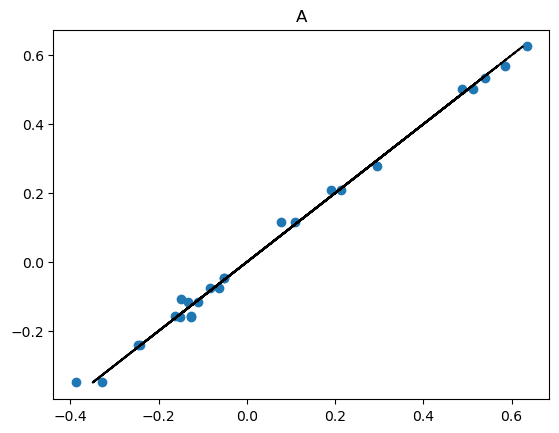

[0.50147337 0.5350051  0.51062477 0.4120058  0.5464349  0.52323586
 0.4223809  0.43389246 0.44637075 0.5333235  0.4949646  0.4010381
 0.46533185 0.50669646 0.45713654 0.508746   0.43576005 0.42636096
 0.44940358 0.4890757  0.45604047 0.38911942 0.54782856 0.5121735
 0.39790094 0.4802663  0.50719446 0.41509554 0.5437633  0.51284784
 0.45057902 0.34573564 0.48920986 0.41750082 0.43205348 0.36980855
 0.48738328 0.3841827  0.5119359  0.4758549  0.54055417 0.5651114
 0.5708152  0.5049755  0.53344244 0.4328546  0.63202363 0.49894044
 0.48432288 0.48044923 0.5224274  0.5042786  0.54210824 0.4012849
 0.50002414 0.56647295 0.5091256  0.5124659  0.5814359  0.44000074
 0.5324824  0.46249288 0.49502817 0.42195588 0.50371534 0.5998371
 0.40299773 0.5034424  0.5720944  0.49933985 0.5784777  0.36575693
 0.4365644  0.5026641  0.54286486 0.4664994  0.38722003 0.48489678
 0.41532245 0.45192686 0.50128704 0.4670543  0.48077095 0.5500223
 0.45277825 0.42290938 0.51433367 0.5219617  0.5374906  0.38240018
 

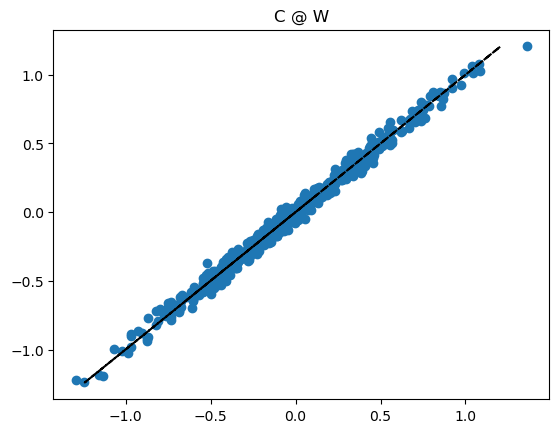

[[[-0.08673946 -0.39447215  0.14408654 -0.07629991 -0.1625185 ]
  [-0.008156    0.11537372  0.05888281  0.01593431  0.31552038]
  [-0.40389028  0.1498631   0.2060388  -0.34245047  0.04431264]
  [ 0.3843012  -0.30661365 -0.44743142  0.33428636 -0.10258608]
  [-0.03963986  0.13007608  0.446542   -0.21720588 -0.1134375 ]]] [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0. -0.  1.]]
tensor([0.0735, 0.0903, 0.0834, 0.2740, 0.1061, 0.1118, 0.1615, 0.0624, 0.0574,
        0.1518, 0.0746, 0.0980, 0.4720, 0.1095, 0.0992, 0.1073, 0.0745, 0.1496,
        0.1416, 0.1169, 0.0716, 0.3477, 0.2013, 0.1111, 0.0223, 0.2989, 0.0969,
        0.0882, 0.0628, 0.0509, 0.3624, 0.4168, 0.0410, 0.0205, 0.2698, 0.4367,
        0.3876, 0.1183, 0.4206, 0.0557, 0.3647, 0.0274, 0.0133, 0.1614, 0.0571,
        0.1166, 0.0757, 0.1067, 0.0662, 0.3349, 0.0647, 0.0586, 0.0386, 0.5492,
        0.0664, 0.1851, 0.1163, 0.1041, 0.0421, 0.0458, 0.0922, 0.0234, 0.1777,
  

In [4]:
# for name, prm in model.named_parameters():
#     if name in ['C', 'W']:
#         continue
#     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')


# # print(C @ W )
# # print(model.C @ model.W)
# print((C@W - (model.C @ model.W).detach().cpu().numpy()))
# # print(C @ W)
# print(model.Sigma0)

plt.plot(model.A.detach().cpu().numpy().flatten(), A.flatten(), 'o')
# plot y = x line 
plt.plot(A.flatten(), A.flatten(), 'k--')
plt.title('A')
plt.show()

print(model.d.detach().cpu().numpy(), _d)

plt.plot((model.C @ model.W).detach().cpu().numpy().flatten(), (C @ W).flatten(), 'o')
# plot y = x line
plt.plot((C @ W).flatten(), (C @ W).flatten(), 'k--')
plt.title('C @ W')
plt.show()

print(model.Sigma0_half.detach().cpu().numpy(), np.linalg.cholesky(Sigma0))

print(model.sigma_x, sigma_x)

print(model.mu0.detach().cpu().numpy(), mu0)

print(model.B, B)


torch.Size([1, 1, 5, 1000])


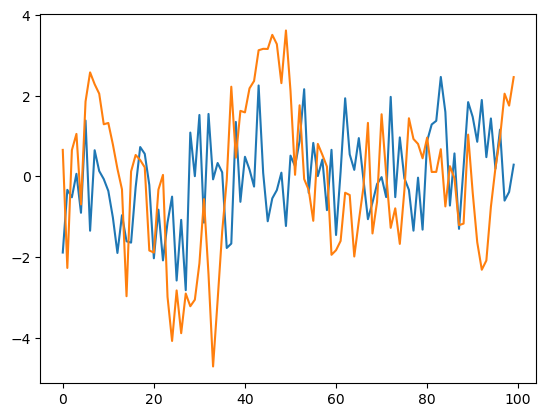

In [5]:
model.freeze_params()
z_samps = model.sample_z(1, trials=1)
print(z_samps.shape)
stop = 100
for i in range(len(z_samps)):
    plt.plot(z_samps[i,0,0, :stop].detach().cpu().numpy())
    plt.plot(z_samps[i,0,1, :stop].detach().cpu().numpy())
    plt.show()

In [6]:
# Load saved neural network
# state_dict = torch.load('my_sequential_model.pth')

m = dill.load(open('synthetic_rec.pkl', 'rb'))
model = m.gen_model
def get_rec_model(m):
    gen = LDS(z = m.gen_model.z, Y = m.gen_model.Y, lik = m.gen_model.lik, x_dim=m.gen_model.x_dim, link_fn=m.gen_model.link_fn, A=m.gen_model.A, C=m.gen_model.C, W=m.gen_model.W, B=m.gen_model.B, mu0=m.gen_model.mu0, Sigma0_half=m.gen_model.Sigma0_half, sigma_x=m.gen_model.sigma_x,
                 trained_z=False, d=m.gen_model.d, fixed_d=True, single_sigma_x=False, full_R=False)
    gen.freeze_params()
    rec_model = RecognitionModel(gen, neural_net=m.neural_net, cov_change=False)
    rec_model.freeze_params()
    return rec_model

100


step 0 LL -1.73534921875 Entropy -0.1538001171875 Joint LL -1.5815490625
step 1 LL -1.6923165625 Entropy -0.1538001171875 Joint LL -1.53851640625
step 2 LL -1.65964796875 Entropy -0.1538001171875 Joint LL -1.5058478125
step 3 LL -1.628485 Entropy -0.1538001171875 Joint LL -1.47468484375
step 4 LL -1.60018578125 Entropy -0.1538001171875 Joint LL -1.446385625
step 5 LL -1.578198359375 Entropy -0.1538001171875 Joint LL -1.424398203125
step 6 LL -1.568028828125 Entropy -0.1538001171875 Joint LL -1.414228671875
step 7 LL -1.5639615625 Entropy -0.1538001171875 Joint LL -1.41016140625
step 8 LL -1.562165 Entropy -0.1538001171875 Joint LL -1.40836484375
step 9 LL -1.56288734375 Entropy -0.1538001171875 Joint LL -1.4090871875
step 10 LL -1.562590078125 Entropy -0.1538001171875 Joint LL -1.408789921875
step 11 LL -1.56226046875 Entropy -0.1538001171875 Joint LL -1.4084603125
step 12 LL -1.560571171875 Entropy -0.1538001171875 Joint LL -1.406771015625
step 13 LL -1.558981640625 Entropy -0.1538001

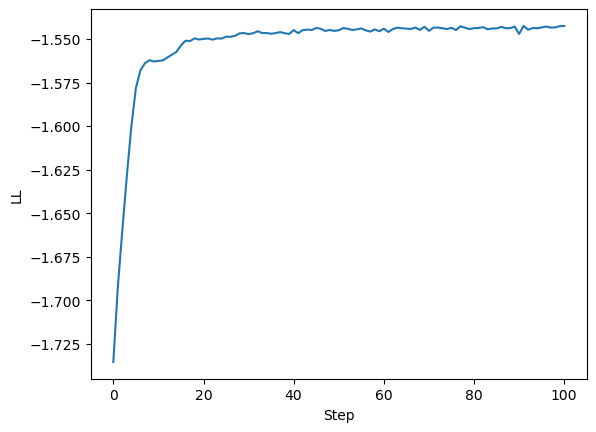

In [7]:

model.freeze_params()
print(model.x_dim)

# class MyRNNModel(Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MyRNNModel, self).__init__()
#         self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
#         self.fc = torch.nn.Linear(hidden_size * 2, output_size)

#     def forward(self, x):
#         out, _ = self.rnn(x)
#         out = self.fc(out)
#         return out

# neural_net = MyRNNModel(model.N, 100, model.x_dim)

# # # Substituting the true parameters
# # neural_net = torch.nn.Sequential(
# #                 torch.nn.Linear(model.N, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 # torch.nn.Linear(100, 100),
# #                 # torch.nn.ReLU(),
# #                 torch.nn.Linear(100, model.x_dim)
# #             )
# # # neural_net.load_state_dict(state_dict)
# # # rec_model = RecognitionModel(model, neural_net=neural_net)

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) # needs ntrials, T, N
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = RNNModel(model.N, 100, model.x_dim)
# neural_net.load_state_dict(state_dict)

rec_model = RecognitionModel(model, rnn=False)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-3, 'max_steps': 101, 'n_mc_x': 50, 'n_mc_z': 50, 'batch_mc_z': 25}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

torch.Size([1, 100, 1000])


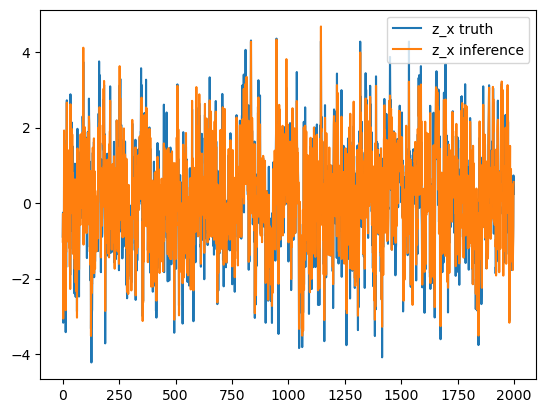

0.9008897074853053 z_0
0.9054129588719293 z_1
0.9199858832403305 z_2
0.9137173184709432 z_3
0.8809886701454082 z_4
(1, 100, 2000)


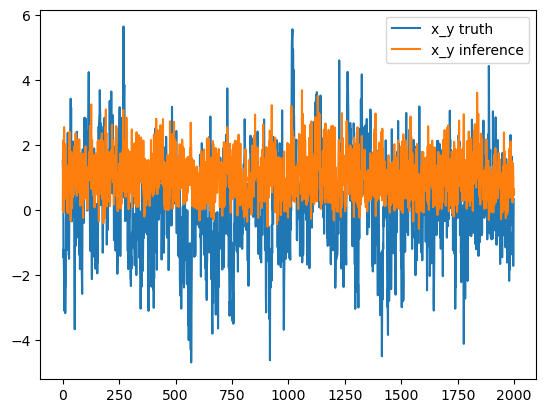

-0.9891284232109738 x_0
-0.5428684382192335 x_1
0.5519004169326631 x_2
0.16167873375869746 x_3
0.4418142629288321 x_4
0.13019904295879137 x_5
0.25879253381323797 x_6
-0.19153982585604856 x_7
-0.1131852032739773 x_8
-0.036223971345159756 x_9
0.19236878468950303 x_10
-1.7928590922386567 x_11
-0.17194612108159713 x_12
-1.697930710243968 x_13
0.18509981749303317 x_14
0.44221640325303124 x_15
0.37381672091275875 x_16
0.6875971192833394 x_17
0.4299640361454551 x_18
0.19805105581055094 x_19
-3.308379064215347 x_20
-0.11614374157899965 x_21
-0.0921142238082473 x_22
0.3287654377080075 x_23
0.6273834695238807 x_24
0.09838521706077397 x_25
-0.24190438059903996 x_26
0.38704428879492214 x_27
0.7316283146474896 x_28
-0.18744841552480795 x_29
-2.9594064379473957 x_30
0.12725991214240628 x_31
-0.6889516644439293 x_32
-0.04686620271448838 x_33
-0.4374717631243348 x_34
-2.9838201924182344 x_35
0.35629629696855303 x_36
-0.1427663850588905 x_37
-0.057926410914363125 x_38
0.6179209842303943 x_39
-16.281422

In [8]:
print(rec_model.gen_model.Y.shape)
z = rec_model.test_z(Tensor(Y).to(device))
z = z.detach().cpu().numpy()

start = 0
stop = -1
plt.plot(v[0,0,start:stop], label = 'z_x truth')
# plt.plot(v[0,1,:100], label = 'z_y truth')
plt.plot(z[0,0,start:stop], label = 'z_x inference')
# plt.plot(z[0,1,:100], label = 'z_y inference')
plt.legend()
plt.show()

# for i in range(5):
#     plt.plot(z[0,i,:stop], label = 'z_x inference')
# plt.show()
# for i in range(5):
#     plt.plot(v[0,i,:stop], label = 'z_x truth')   
#     # plt.legend()
# plt.show()

# print R^2 for x and y decoding using sklearn
# print(r2_score(v[0,1,:], z[0,1,:]))
# print(r2_score(v[0,0,:], z[0,0,:]))
for i in range(rec_model.gen_model.b):
    print(r2_score(v[0,i,train_len:], z[0,i,train_len:]), 'z_{}'.format(i))

x_tilde = rec_model.get_x_tilde(Tensor(Y).to(device)).detach().cpu().numpy()
print(x_tilde.shape)
stop = -1
# plt.plot(x_noise_free[0,0,:stop], label = 'x_x truth')
# plt.plot(x_tilde[0,0,:stop], label = 'x_x inference')
plt.plot(x_noise_free[0,1,:stop], label = 'x_y truth')
plt.plot(x_tilde[0,1,:stop], label = 'x_y inference')
plt.legend()
plt.show()
# print R^2 for x_tilde
for i in range(rec_model.gen_model.x_dim):
    print(r2_score(x_noise_free[0,i,:], x_tilde[0,i,:]), 'x_{}'.format(i))
# print(r2_score(x_noise_free[0,0,:], x_tilde[0,0,:]), 'x_x')
# print(r2_score(x_noise_free[0,1,:], x_tilde[0,1,:]), 'x_y')
# print(r2_score(x_noise_free, x_tilde), 'x_all')

# _, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
# _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ..., :train_len]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# # _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x[None, ...]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# mus_smooth = mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0)
# print(mus_smooth.shape)
# stop = 100
# plt.plot(v[0,0,:stop], label = 'z_x truth')
# plt.plot(mus_smooth[0, 0,:stop], label = 'z_x inference')
# plt.plot(v[0,1,:stop], label = 'z_y truth')
# plt.plot(mus_smooth[0, 1,:stop], label = 'z_y inference')
# plt.legend()
# plt.show()

# # print R^2 for x and y smoothing using sklearn
# print(r2_score(v[0,1,:], mus_smooth[0, 1,:]))
# print(r2_score(v[0,0,:], mus_smooth[0, 0,:]))


In [9]:
_A = Tensor(A).to(device)
_W = Tensor(W).to(device)
_Q = Tensor(B @ B.T).to(device)
_R = Tensor(np.eye(N) * sigma_x**2).to(device)
_Sigma0 = Tensor(Sigma0).to(device)
_mu0 = Tensor(mu0).to(device)
gaussian_Y = Tensor(Y - Y.mean(2)[..., None]).to(device)
_, _, Ks, Cs = general_kalman_covariance(A=_A, W=_W, Q=_Q, R=_R, b=z_dim, x_dim=x_dim, Sigma0=_Sigma0, T=2000, get_sigma_tilde=False, smoothing=True)
_, gaussian_mus_smooth, _ = general_kalman_means(A=_A, W=_W, b=z_dim, mu0=_mu0, x_hat=gaussian_Y[None, ...], Ks=Ks, Cs=Cs, smoothing=True)

torch.Size([2000, 1, 1, 5])
0.7840359015975084
0.7870440645095884
0.7965260065831103
0.7885589265264047
0.7882677710919533


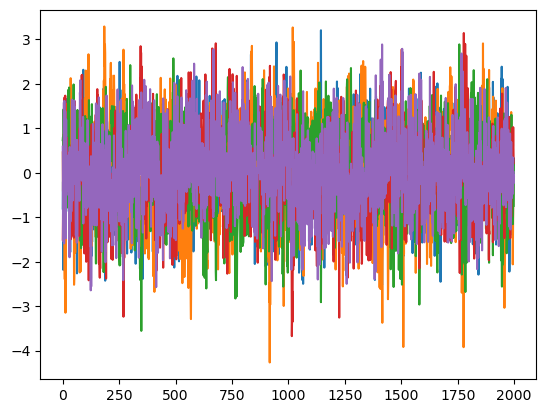

In [10]:
print(gaussian_mus_smooth.shape) # (T, n_mc, ntrials, b)
gaussian_z = gaussian_mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0) # (ntrials, b, T)
for i in range(5):
    plt.plot(gaussian_z[0,i,:stop], label = 'z inf')
    print(r2_score(v[0,i,:], gaussian_z[0,i,:]))

In [25]:
# Checking what sampled posteriors look like
matheron_pert = rec_model.sample_matheron_pert(100, 1)
print(matheron_pert.shape)
# x_hat = Tensor(x[None, ...]).to(device) - matheron_pert[..., :x_tilde.shape[-1]]
x_hat = Tensor(x_noise_free[None, :, :, :train_len]).to(device) - matheron_pert
print(x_hat.shape)
# _, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
_ , _mus_smooth, _ = rec_model.kalman_means(x_hat, Ks, Cs) # (batch_size, n_mc_z, ntrials, b)
_mus_smooth = _mus_smooth.permute(1,2,3,0).squeeze().detach().cpu().numpy()
print(_mus_smooth.shape)

# True posterior mean
_ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ..., :train_len]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
mus_smooth = mus_smooth.detach().cpu().numpy().squeeze().T
print(mus_smooth.shape)

torch.Size([100, 1, 100, 1000])
torch.Size([100, 1, 100, 1000])
(100, 5, 1000)
(5, 1000)


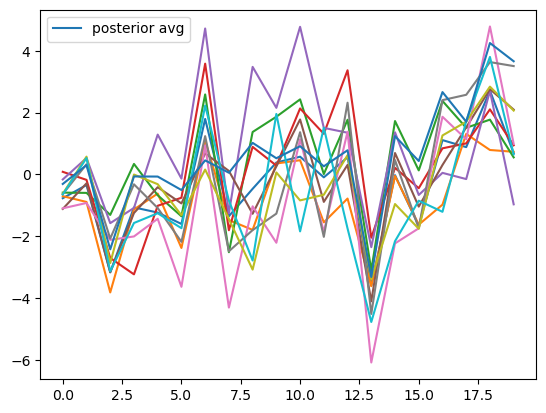

0.9878795933412897
0.988433934323742


In [26]:
# stop = 100
# for i in range(len(_mus_smooth)):
#     plt.plot(_mus_smooth[i,0,:stop])
#     # plt.plot(_mus_smooth[i,0,1,:stop])
#     # plt.show()
# plt.show()

stop = 20
posterior_avg = _mus_smooth.mean(0)
posterior_std = _mus_smooth.std(0)
# prior_avg = z_samps.mean(0)
plt.plot(posterior_avg[0,:stop], label = 'posterior avg')
# plt.plot(mus_smooth[0,:stop], label = 'smoothing')
# plt.plot(prior_avg[0,:stop], label = 'prior avg')
# plt.plot(z_samps[0,0,:stop], label = 'prior sample')
for i in range(10):
    plt.plot(_mus_smooth[i,0,:stop])
plt.legend()
plt.show()
# print R^2 between posterior mean and smoothing
print(r2_score(mus_smooth[0,:], posterior_avg[0,:]))
print(r2_score(mus_smooth[1,:], posterior_avg[1,:]))

In [29]:
# dill.dump(rec_model, open('synthetic_rec.pkl', 'wb'))